In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torchdiffeq import odeint, odeint_adjoint

In [22]:
def plot_data(data):
    plt.figure(figsize=(10, 3))
    plt.scatter(data['Time'], data['Glucose'], label='Glucose', s=10, color='blue')
    plt.scatter(data['Time'], data['Biomass'], label='Biomass', s=10, color='green')
    plt.scatter(data['Time'], data['Protein'], label='Protein', s=10, color='red')
    plt.legend()
    plt.show()

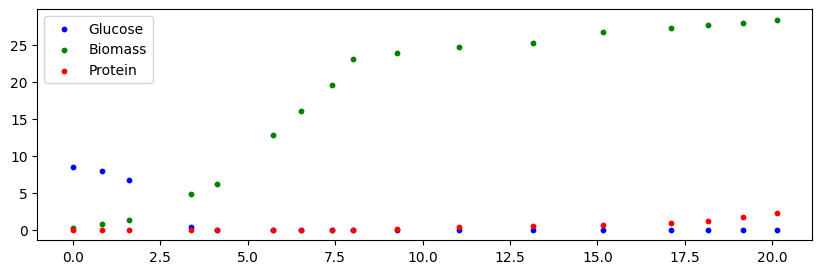

In [23]:
#  Read BR data
data = pd.read_excel('../Bioindustry/data/BR02_for_model.xlsx', header=0).drop(0, axis=0)
t_start = data['Time'].iloc[0]
t_end = data['Time'].iloc[-1]
t_span = [t_start, t_end]

t = torch.tensor(data['Time'].values.astype(np.float32)) 
y_0 = torch.tensor([data['Glucose'].iloc[0], data['Biomass'].iloc[0], data['Protein'].iloc[0]], dtype=torch.float32)
y_true = torch.tensor(data[['Glucose', 'Biomass', 'Protein']].values.astype(np.float32))

plot_data(data)

In [24]:
# NODE
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.GELU(),
            nn.Linear(50, 50),
            nn.GELU(),
            nn.Linear(50, 50),
            nn.GELU(),
            nn.Linear(50, 3)
        )

    def forward(self, t, y):
        return self.net(y)
    
n_iters = 10000
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=0.0005)
criterion = nn.MSELoss()

LOSS = []
for iter in range(n_iters+1):
    optimizer.zero_grad()
    y_pred = odeint(func, y0=y_0, t=t, method='dopri5') 
    loss = criterion(y_pred, y_true)
    LOSS.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if iter % 50 == 0:
        print(f'Iter {iter}, Loss {loss.item()}')


Iter 0, Loss 126.13468170166016
Iter 50, Loss 3.526914358139038
Iter 100, Loss 3.0075111389160156
Iter 150, Loss 2.7047555446624756
Iter 200, Loss 2.433553457260132
Iter 250, Loss 2.167508840560913
Iter 300, Loss 1.9683538675308228
Iter 350, Loss 1.7683194875717163
Iter 400, Loss 1.5911595821380615
Iter 450, Loss 1.3903340101242065
Iter 500, Loss 1.24885892868042
Iter 550, Loss 1.1687333583831787
Iter 600, Loss 1.0760146379470825
Iter 650, Loss 1.101696491241455
Iter 700, Loss 1.0982656478881836
Iter 750, Loss 0.8285784721374512
Iter 800, Loss 0.7228501439094543
Iter 850, Loss 0.7783616185188293
Iter 900, Loss 0.860321044921875
Iter 950, Loss 0.7849996089935303
Iter 1000, Loss 0.6479803323745728
Iter 1050, Loss 0.5424677133560181
Iter 1100, Loss 0.5456816554069519
Iter 1150, Loss 0.8547763228416443
Iter 1200, Loss 0.4789625406265259
Iter 1250, Loss 0.4905688762664795
Iter 1300, Loss 0.491241455078125
Iter 1350, Loss 0.37437957525253296
Iter 1400, Loss 0.3330782651901245
Iter 1450, Loss

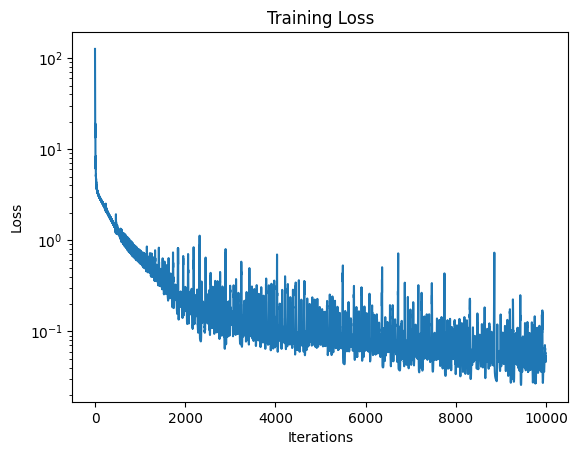

In [25]:
# Plot training loss
plt.plot(LOSS)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [32]:
# Save trained torch model
torch.save(func.state_dict(), 'model.pth')


In [42]:
# Load trained torch model
m = ODEFunc()
m.load_state_dict(torch.load('model.pth'))
m.eval()

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=50, out_features=3, bias=True)
  )
)

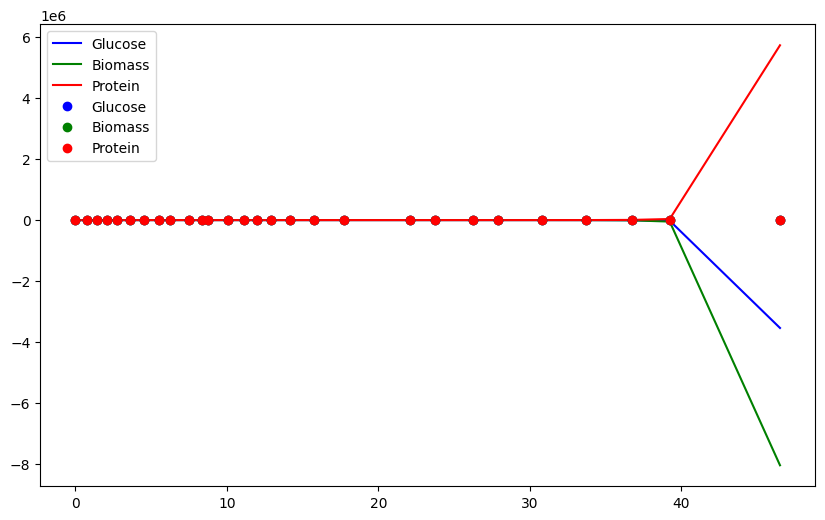

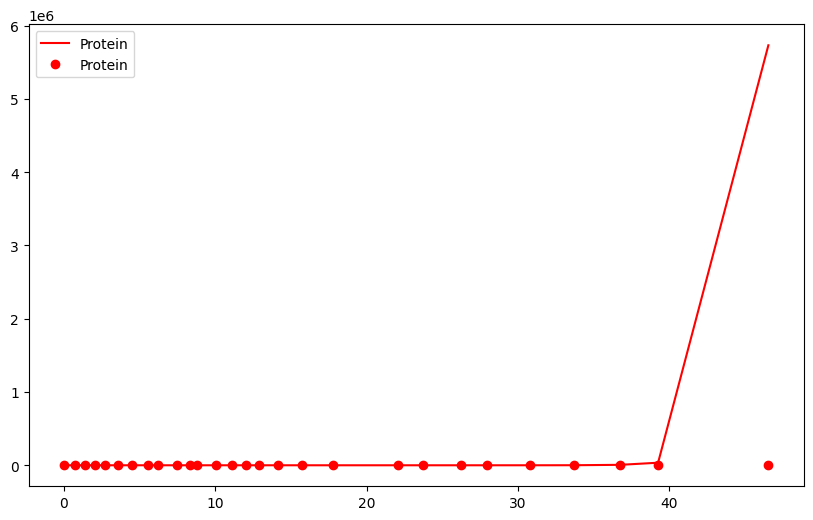

In [43]:
# Plot
y_pred = odeint(m, y0=y_0, t=t, method='dopri5')

plt.figure(figsize=(10, 6))
plt.plot(t.detach().numpy(), y_pred[:, 0].detach().numpy(), label='Glucose', color='blue')
plt.plot(t.detach().numpy(), y_pred[:, 1].detach().numpy(), label='Biomass', color='green')
plt.plot(t.detach().numpy(), y_pred[:, 2].detach().numpy(), label='Protein', color='red')
plt.plot(t.detach().numpy(), data['Glucose'], label='Glucose', color='blue', marker='o', linestyle='None')
plt.plot(t.detach().numpy(), data['Biomass'], label='Biomass', color='green', marker='o', linestyle='None')
plt.plot(t.detach().numpy(), data['Protein'], label='Protein', color='red', marker='o', linestyle='None')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t.detach().numpy(), y_pred[:, 2].detach().numpy(), label='Protein', color='red')
plt.plot(t.detach().numpy(), data['Protein'], label='Protein', color='red', marker='o', linestyle='None')
plt.legend()
plt.show()

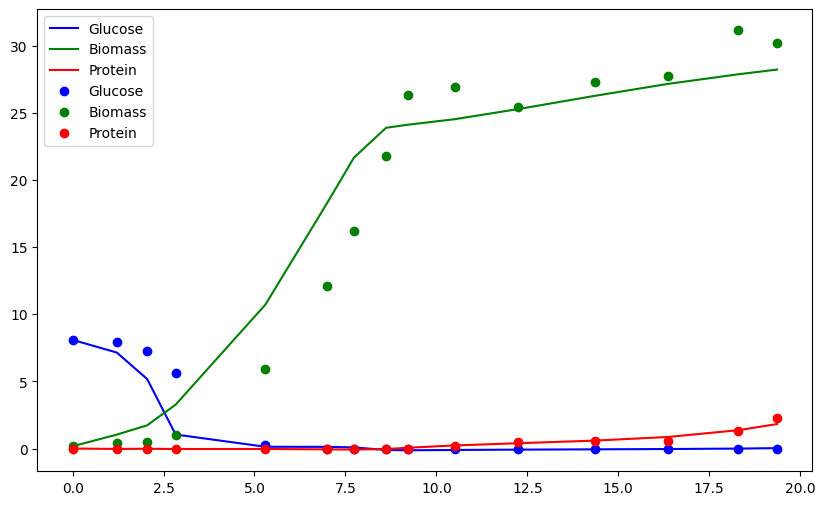

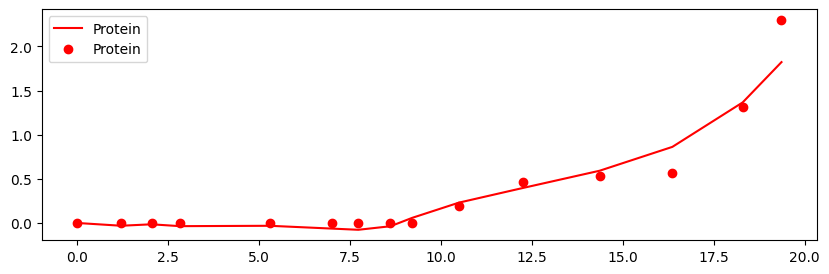

In [46]:
data = pd.read_excel('../Bioindustry/data/BR03_for_model.xlsx', header=0).drop(0, axis=0)
t_start = data['Time'].iloc[0]
t_end = data['Time'].iloc[-1]
t_span = [t_start, t_end]

# plot_data(data)
t = torch.tensor(data['Time'].values.astype(np.float32)) 
y_0 = torch.tensor([data['Glucose'].iloc[0], data['Biomass'].iloc[0], data['Protein'].iloc[0]], dtype=torch.float32)
y_true = torch.tensor(data[['Glucose', 'Biomass', 'Protein']].values.astype(np.float32))

y_pred = odeint(func, y0=y_0, t=t, method='dopri5')

plt.figure(figsize=(10, 6))
plt.plot(t.detach().numpy(), y_pred[:, 0].detach().numpy(), label='Glucose', color='blue')
plt.plot(t.detach().numpy(), y_pred[:, 1].detach().numpy(), label='Biomass', color='green')
plt.plot(t.detach().numpy(), y_pred[:, 2].detach().numpy(), label='Protein', color='red')
plt.plot(t.detach().numpy(), data['Glucose'], label='Glucose', color='blue', marker='o', linestyle='None')
plt.plot(t.detach().numpy(), data['Biomass'], label='Biomass', color='green', marker='o', linestyle='None')
plt.plot(t.detach().numpy(), data['Protein'], label='Protein', color='red', marker='o', linestyle='None')
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t.detach().numpy(), y_pred[:, 2].detach().numpy(), label='Protein', color='red')
plt.plot(t.detach().numpy(), data['Protein'], label='Protein', color='red', marker='o', linestyle='None')
plt.legend()
plt.show()

In [28]:
p

NameError: name 'p' is not defined